In [7]:
##### ✅ PART 1: Load Data and Create Labels
import pandas as pd

TRAIN_PATH = (
    r"C:\Users\Sina\Desktop\CODES\Sources\5(CLASSIFICATION)\1(NAIVEBAYES)\1(user_courses_review_09_2023).csv"
)
TEST_PATH = (
    r"C:\Users\Sina\Desktop\CODES\Sources\5(CLASSIFICATION)\1(NAIVEBAYES)\2(user_courses_review_test_set).csv"
)

# Load separate files
df_train = pd.read_csv(TRAIN_PATH, on_bad_lines="skip", quotechar='"')
df_test  = pd.read_csv(TEST_PATH,  on_bad_lines="skip", quotechar='"')

# Standard column names
df_train.columns = ["course_name", "lecture_name", "review_rating", "review_comment"]
df_test.columns  = ["course_name", "lecture_name", "review_rating", "review_comment"]

# Clean each set
for df in (df_train, df_test):
    df.dropna(subset=["review_rating", "review_comment"], how="all", inplace=True)
    df["review_comment"] = df["review_comment"].fillna("")
    df["review_rating"]  = pd.to_numeric(df["review_rating"], errors="coerce")
    df.dropna(subset=["review_rating"], inplace=True)
    df["label"] = df["review_rating"].apply(lambda x: 1 if x >= 4 else 0)

# Keep only what we need
df_train = df_train[["review_comment", "label"]]
df_test  = df_test[["review_comment", "label"]]
df_test

,review_comment,label
0,perfect,1
1,The SCRUM chapter are full of errors,0
2,Bad quality of audio and narrative,0
3,I need documentation about lecture.,0
4,Great course! Ned has a talent for explaining ...,1
...,...,...
149,NOT WORTH IT,0
150,Nice,1
151,Information was great.,1
152,great\n,1


In [2]:
##### ✅ PART 2: Text Pre-processing (unchanged)
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text  = text.lower()
    text  = text.translate(str.maketrans("", "", string.punctuation))
    text  = re.sub(r"\d+", "", text)
    words = [
        lemmatizer.lemmatize(w)
        for w in text.split()
        if w not in stop_words
    ]
    return " ".join(words)

df_train["cleaned_comment"] = df_train["review_comment"].apply(clean_text)
df_test["cleaned_comment"]  = df_test["review_comment"].apply(clean_text)


<ipython-input-2-ab7f787f4018>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["cleaned_comment"]  = df_test["review_comment"].apply(clean_text)


In [3]:
##### ✅ PART 3: Vectorise + SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

X_train_raw = df_train["cleaned_comment"]
y_train     = df_train["label"]
X_test_raw  = df_test["cleaned_comment"]
y_test      = df_test["label"]

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf  = vectorizer.transform(X_test_raw)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)


In [4]:
##### ✅ PART 4: Train Naive Bayes
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_balanced, y_train_balanced)


MultinomialNB()

Accuracy Score: 0.8506493506493507 

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.87      0.53        15
           1       0.98      0.85      0.91       139

    accuracy                           0.85       154
   macro avg       0.68      0.86      0.72       154
weighted avg       0.92      0.85      0.87       154



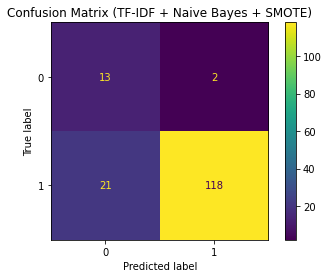

In [5]:
##### ✅ PART 5: Evaluate on External Test Set
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_tfidf)

print("Accuracy Score:", accuracy_score(y_test, y_pred), "\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix (TF-IDF + Naive Bayes + SMOTE)")
plt.show()
